##  Implementation of FreezeOut method with ResNet on tensorflow and dataset
* FreezeOut: https://arxiv.org/abs/1706.04983
* ResNet: https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py

In this notebook we research how works freezeout method with small version of ResNet. The main idea of FreezeOut very simple. The early layers of a deep neural net have the fewest parameters, but take up the most computation.
For this reason lets freezing layers one-by-one and excluding them from the backward pass.

Every layer(in our implementation, from each module: conv-block, or indentity-block) have own learning rate and turn-off after own number of iterations. Layers are excluded in order from early to higher layers.
For each block learning rate given as:
$$
\alpha_{i}(t) = 0.5 + \alpha_{i}(0)(1 + \cos( \frac {\pi t}{t_{i}} ))
$$
where:


$$\alpha_{i}(t) - Values\ of\ learning\ rate\ form\ i-th\ layer. \\
\alpha_i(0) - The\ initial\ layerwise\ learning\ rate. If\ you\ use\ scaled\ method\, then\ \alpha_i(0) = \frac{\alpha}{t_i}\ else, \alpha - same\ for\ all\ layers.\\
t - The\ number\ of\ the\ current\ iteration. \\
t_i - The\ number\ of\ last\ iteration. After\ this\ iteration\ layer\ learning\ rate\ will\ be\ zero.\\
$$
For an experiment, after the last layer will be disable, we turn-on all layers and continue the train, with learning rate = 1e-2.

In paper authors suggest of two ways, how choose last iteration to disable layer:
* __Linear__ - choose the total number of iterations(t) and percentage, after which layer will disabled. t_i all remaining layers will linearly spaced between t and t_0.
* __Cube__ - All same, but a percentage will spaced id cube dependencies.


In [1]:
import os
import sys

import blosc
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from collections import OrderedDict
%matplotlib inline

sys.path.append('..')
from batch import ResBatch
from dataset import Dataset, DatasetIndex, Batch, action, model

### We took most oplimal params to models and show their on graph presented below

In [52]:
optimal_params = {'iteration': [300] * 4,
                  'learning_rate': [0.04, 0.06, 10, 14],
                  'degree': [3, 1, 3, 1],
                  'scaled': [False] * 2 + [True] * 2}
optimal_params = OrderedDict(sorted(optimal_params.items(), key=lambda x: x[0]))

### About params:
* Iteration - Number of last iteration for model with FreezeOut, after this iteration, learning rates in all layers will be zero.
* learning rate - Basic learning rate for all layers. In scaled method it will be divided by number of last iteration for this layer.
* degree - __Linear__ or __Cube__, or __Square__ dependency for disable layers.
* scaled - __scaled__(True) of __unscaled__(False) method of disable layers.

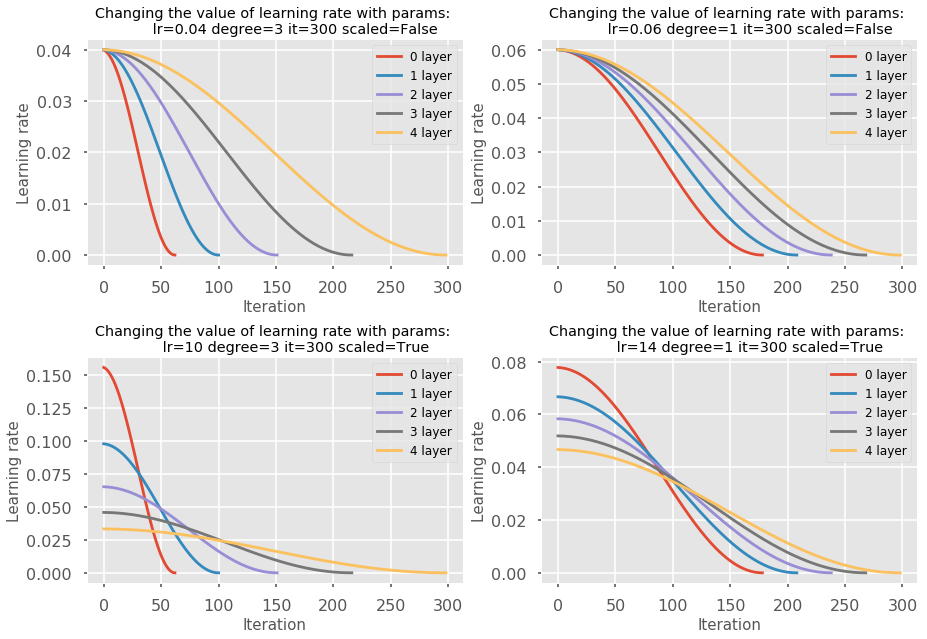

In [3]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')


iteration = 300
_, axarr = plt.subplots(2, 2)
axarr=axarr.reshape(-1)

for params in range(4):
    graph = []
    for i in range(1, 6):
        gefault_learning = optimal_params['learning_rate'][params]
        last = int(iteration*(i/10  + 0.5) ** optimal_params['degree'][params])
        if optimal_params['scaled'][params] == True:
            graph.append([0.5 * gefault_learning/last * (1 + np.cos(np.pi * i / last)) for i in range(2, last+1)])
        else:
            graph.append([0.5 * gefault_learning * (1 + np.cos(np.pi * i / last)) for i in range(2, last+1)])
   

    for i in range(len(graph)):
        axarr[params].set_title('Changing the value of learning rate with params: \n \
        lr={} degree={} it={} scaled={}'.format(gefault_learning, optimal_params['degree'][params], \
                                                             300, optimal_params['scaled'][params] ))
        axarr[params].plot(graph[i], label='{} layer'.format(i)) 
        axarr[params].set_xlabel('Iteration', fontsize=15)
        axarr[params].set_ylabel('Learning rate', fontsize=15)
    axarr[params].legend(fontsize=12)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### Load MNIST

In [4]:
src = './../MNIST_data'
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    images = blosc.unpack_array(file.read()).reshape(-1, 28, 28)
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    labels = blosc.unpack_array(file.read())

### Create pipeline and train it with optimal params for compare Resnet  model with FreezeOut and clear Resnet


In [5]:
global_freeze_loss = []
ix = DatasetIndex(range(50000))
pipelines = []

In [6]:
res_loss=[]
test_dset = Dataset(ix, ResBatch)
test_pipeline = (test_dset.
                 p.
                 train_res(res_loss, images[:50000], labels[:50000]))
for i in tqn(range(500)):
    test_pipeline.next_batch(300,n_epochs=None, shuffle=2)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [8]:
def draw(freeze_loss, res_loss, src):
    """ Draw graphs to compare models. The graph shows a comparison of the average 
        values calculated with a window in 10 values.
    Args:
        freeze_loss: List with loss value in resnet and freezeout model
        res_loss: List with loss value in clear resnet
        src: List with parameters of model with FreezeOut
        ax: Plt sublot """
    fr_loss = []
    n_loss = []

    for i in range(10, len(freeze_loss) - 10):
        fr_loss.append(np.mean(freeze_loss[i-10:i+10]))
        n_loss.append(np.mean(res_loss[i-10:i+10]))
    
    
    plt.title('Freeze model with:  LR={} Degree={} It={} Scaled={}'.format(*src))
    plt.plot(fr_loss, label='freeze loss')
    plt.plot(n_loss, label='no freeze loss')
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(fontsize=14)
    plt.show()

In [40]:
params_list = pd.DataFrame(optimal_params).values
for params in tqn(params_list):
    freeze_loss = []
    
    dataset = Dataset(ix, batch_class=ResBatch)
    pipeline = (dataset.
                      p.
                      initializer(params).
                      train_freez(freeze_loss, images[:50000], labels[:50000]))

    for i in tqn(range(1, 501)):
        pipeline.next_batch(300, n_epochs=None, shuffle=2)

    global_freeze_loss.append(freeze_loss)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


### Let's draw out results

In [54]:
def ax_draw(freeze_loss, res_loss, src, ax):
    """ Draw graphs to compare models. The graph shows a comparison of the average 
        values calculated with a window in 10 values.
    Args:
        freeze_loss: List with loss value in resnet and freezeout model
        res_loss: List with loss value in clear resnet
        src: List with parameters of model with FreezeOut
        ax: Plt sublot """
    fr_loss = []
    n_loss = []

    for i in range(10, len(res_loss) - 10):
        fr_loss.append(np.mean(freeze_loss[i-10:i+10]))
        n_loss.append(np.mean(res_loss[i-10:i+10]))
    
    
    ax.set_title('Freeze model with:  LR={} Degree={} It={} Scaled={}'.format(*src))
    ax.plot(fr_loss, label='freeze loss')
    ax.plot(n_loss, label='no freeze loss')
    ax.set_xlabel('Iteration', fontsize=16)
    ax.set_ylabel('Loss', fontsize=16)
    ax.legend(fontsize=14)

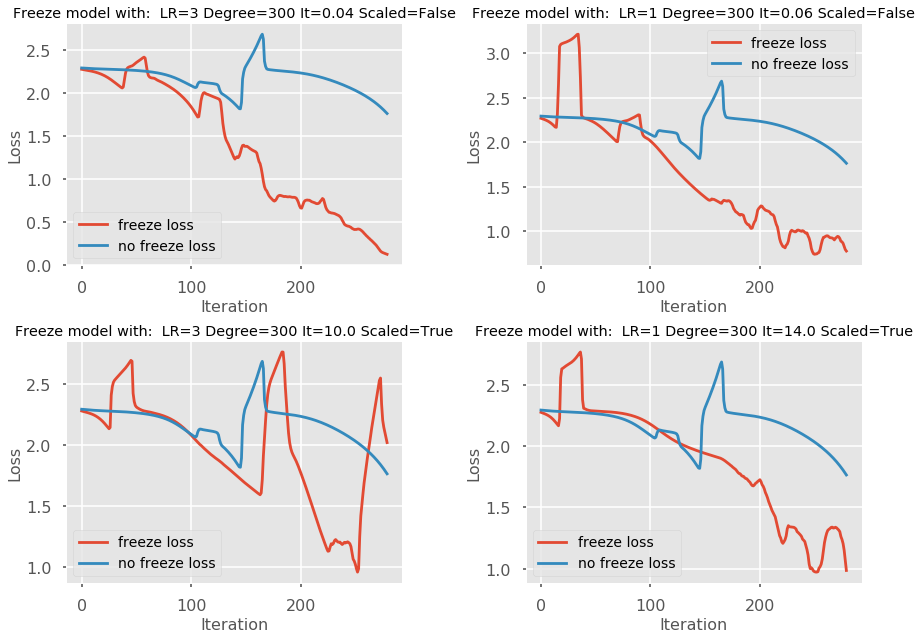

In [55]:
_, ax = plt.subplots(2,2)
ax = ax.reshape(-1)
for i in range(4):
    ax_draw(global_freeze_loss[i][:300], res_loss[:300], params_list[i], ax[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### In these graphs we see the dynamics of models and models with uscaled method more unsustainable, because their learning rate bigger then in scaled method. 
### Geat leaps in loss are explained by the large momentum.

### Not difficult to see, what loss of model with freezeout falls faster, than common model. After several iteration loss of freezeout model goes on the plato, but loss common resnet continues to fall.

### Now if we continue to train models and we can see, how will affect new learning rate(1e-2 is the same for all layers) on loss value.

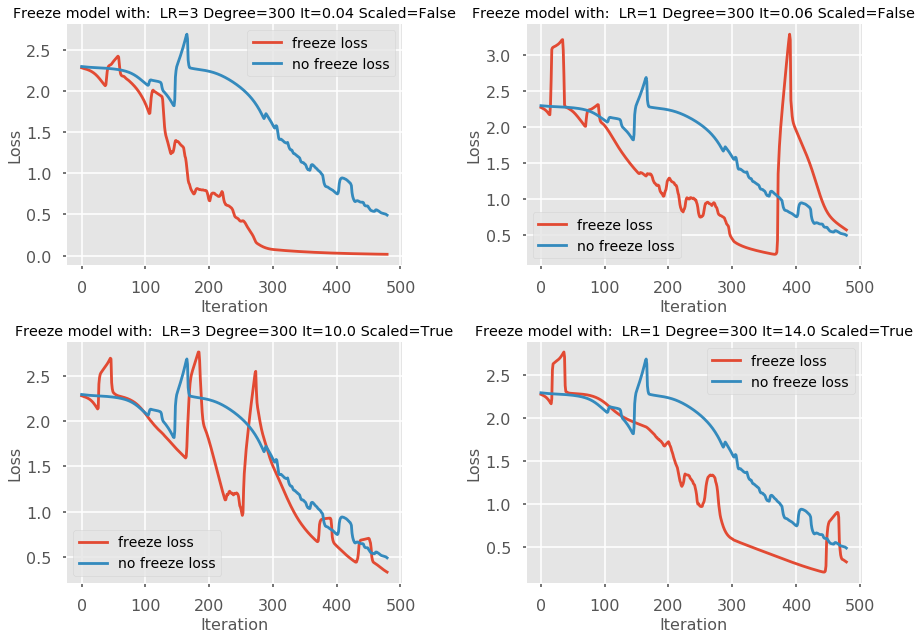

In [56]:
_, ax = plt.subplots(2,2)
ax = ax.reshape(-1)
for i in range(4):
    ax_draw(global_freeze_loss[i], res_loss, params_list[i], ax[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

All the experiments we conducted on the mnist dataset, and made the following conclusions:
* All experiments were carried out on a small number of iterations and for this reason all models was very unsustainable.
* Method FreezeOut really might be useful in network with skip-connection layers. This method gives speed in iteration, but loses models without freezeout in time for training model in 3 or 4 times.
* If we return learning rate form zero in all layers, model might be give best results from several iterations.
* We could not achieve normal results with scaled learning rate, because the learning rate on higher layers will be very small and network could not train.
* On not a large number of iterations linear methods work better, than cube.